# C247 Final Project - EEG
-   Date: Mar 15th



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from collections import defaultdict

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers, models, regularizers, optimizers

In [ ]:
tf.test.is_built_with_cuda()

False

In [ ]:
X_test = np.load("X_test.npy")
y_test = np.load("y_test.npy")
person_train_valid = np.load("person_train_valid.npy")
X_train_valid = np.load("X_train_valid.npy")
y_train_valid = np.load("y_train_valid.npy")
person_test = np.load("person_test.npy")

### Shape of data

In [ ]:
print ('Training/Valid data shape: {}'.format(X_train_valid.shape))
print ('Test data shape: {}'.format(X_test.shape))
print ('Training/Valid target shape: {}'.format(y_train_valid.shape))
print ('Test target shape: {}'.format(y_test.shape))
print ('Person train/valid shape: {}'.format(person_train_valid.shape))
print ('Person test shape: {}'.format(person_test.shape))

Training/Valid data shape: (2115, 22, 1000)
Test data shape: (443, 22, 1000)
Training/Valid target shape: (2115,)
Test target shape: (443,)
Person train/valid shape: (2115, 1)
Person test shape: (443, 1)


### Decoding and Visualizing

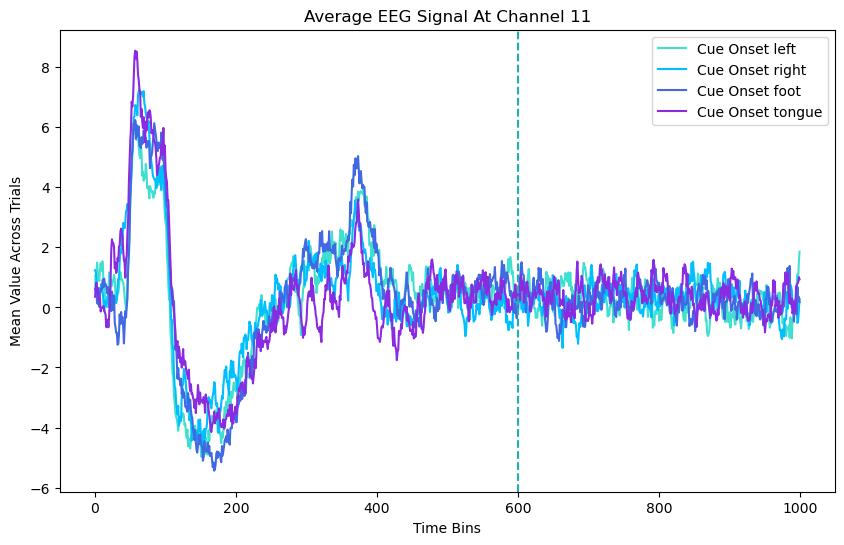

In [ ]:
## Adjusting the labels so that

# Cue onset left - 0
# Cue onset right - 1
# Cue onset foot - 2
# Cue onset tongue - 3

y_train_valid -= 769
y_test -= 769

## Visualizing the data

ch_data = X_train_valid[:,11,:]


class_0_ind = np.where(y_train_valid == 0)
ch_data_class_0 = ch_data[class_0_ind]
avg_ch_data_class_0 = np.mean(ch_data_class_0,axis=0)


class_1_ind = np.where(y_train_valid == 1)
ch_data_class_1 = ch_data[class_1_ind]
avg_ch_data_class_1 = np.mean(ch_data_class_1,axis=0)

class_2_ind = np.where(y_train_valid == 2)
ch_data_class_2 = ch_data[class_2_ind]
avg_ch_data_class_2 = np.mean(ch_data_class_2,axis=0)

class_3_ind = np.where(y_train_valid == 3)
ch_data_class_3 = ch_data[class_3_ind]
avg_ch_data_class_3 = np.mean(ch_data_class_3,axis=0)


plt.figure(figsize=(10, 6))  # Adjust the figure size as needed

# Plot each class with a cool color
plt.plot(np.arange(1000), avg_ch_data_class_0, color='turquoise', label="Cue Onset Left")
plt.plot(np.arange(1000), avg_ch_data_class_1, color='deepskyblue', label="Cue Onset Right")
plt.plot(np.arange(1000), avg_ch_data_class_2, color='royalblue', label="Cue Onset Foot")
plt.plot(np.arange(1000), avg_ch_data_class_3, color='blueviolet', label="Cue Onset Tongue")

plt.axvline(x=600, label='Cue Onset', c='lightseagreen', linestyle='--')  # Make the cue onset line in a cool color

plt.title("Average EEG Signal At Channel 11")

plt.xlabel("Time Bins")
plt.ylabel("Mean Value Across Trials")


plt.legend(["Cue Onset left", "Cue Onset right", "Cue Onset foot", "Cue Onset tongue"])
plt.show()

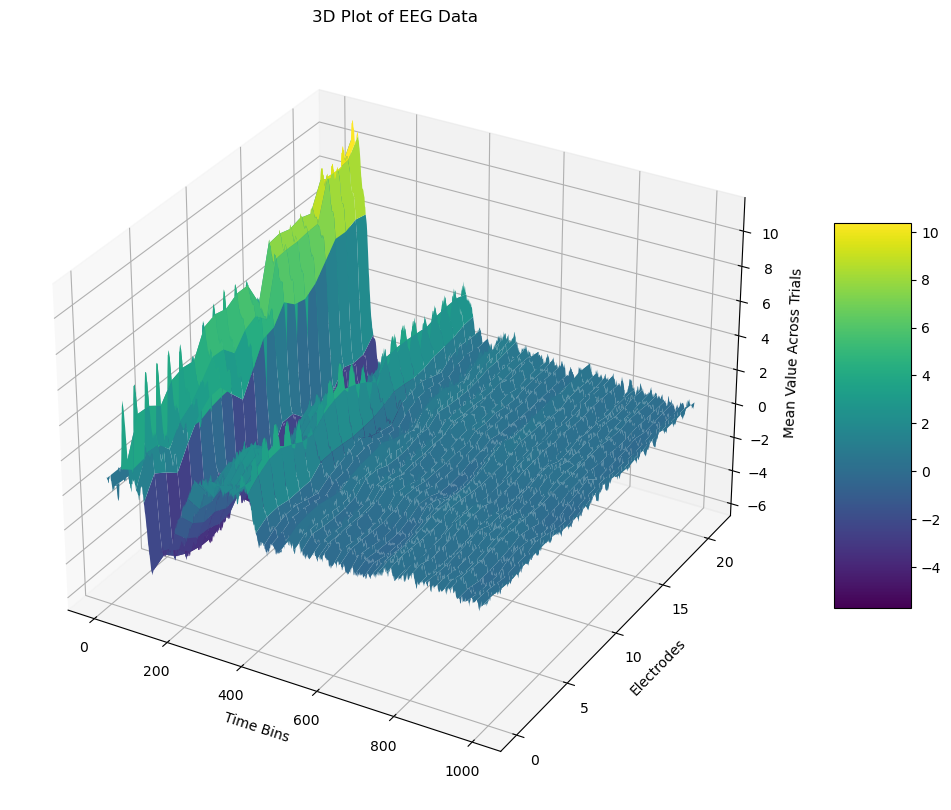

In [ ]:
mean_across_trials = np.mean(X_train_valid, axis=0)

time_bins = np.arange(1000)  # X axis - 1000 time bins
electrodes = np.arange(22)   # Y axis - 22 electrodes

T, E = np.meshgrid(time_bins, electrodes)

# Create a 3D plot
fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111, projection='3d')

# Plotting
surf = ax.plot_surface(T, E, mean_across_trials, cmap='viridis', edgecolor='none')
ax.set_xlabel('Time Bins')
ax.set_ylabel('Electrodes')
ax.set_zlabel('Mean Value Across Trials')
ax.set_title('3D Plot of EEG Data')

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()


## Data Processing

In [ ]:
def train_data_prep(X,y,sub_sample,average,noise):

    total_X = None
    total_y = None

    # Trimming the data (sample,22,1000) -> (sample,22,600)
    X = X[:,:,0:600]
    print('Shape of X after trimming:',X.shape)

    # Maxpooling the data (sample,22,800) -> (sample,22,800/sub_sample)
    X_max = np.max(X.reshape(X.shape[0], X.shape[1], -1, sub_sample), axis=3)


    total_X = X_max
    total_y = y
    print('Shape of X after maxpooling:',total_X.shape)

    # Averaging + noise
    X_average = np.mean(X.reshape(X.shape[0], X.shape[1], -1, average),axis=3)
    X_average = X_average + np.random.normal(0.0, 0.5, X_average.shape)

    total_X = np.vstack((total_X, X_average))
    total_y = np.hstack((total_y, y))
    print('Shape of X after averaging+noise and concatenating:',total_X.shape)

    # Subsampling

    for i in range(sub_sample):

        X_subsample = X[:, :, i::sub_sample] + \
                            (np.random.normal(0.0, 0.5, X[:, :,i::sub_sample].shape) if noise else 0.0)

        total_X = np.vstack((total_X, X_subsample))
        total_y = np.hstack((total_y, y))


    print('Shape of X after subsampling and concatenating:',total_X.shape)
    print('Shape of Y:',total_y.shape)
    return total_X,total_y


def test_data_prep(X):

    total_X = None


    # Trimming the data (sample,22,1000) -> (sample,22,600)
    X = X[:,:,0:600]
    print('Shape of X after trimming:',X.shape)

    # Maxpooling the data (sample,22,800) -> (sample,22,800/sub_sample)
    X_max = np.max(X.reshape(X.shape[0], X.shape[1], -1, 2), axis=3)


    total_X = X_max
    print('Shape of X after maxpooling:',total_X.shape)

    return total_X


########################################################################

def segment_data_by_subject(x_test, y_test, person_test):
    x_test_by_subject = defaultdict(list)
    y_test_by_subject = defaultdict(list)

    for i, subject_id_array in enumerate(person_test):
        subject_id = int(subject_id_array[0])
        x_test_by_subject[subject_id].append(x_test[i])
        y_test_by_subject[subject_id].append(y_test[i])

    for subject_id in x_test_by_subject:
        x_test_by_subject[subject_id] = np.array(x_test_by_subject[subject_id])
        y_test_by_subject[subject_id] = np.array(y_test_by_subject[subject_id])

    return x_test_by_subject, y_test_by_subject


def evaluate_and_plot(model, x_test_by_subject, y_test_by_subject):
    subject_accuracies = {}

    for subject_id in sorted(x_test_by_subject.keys()):
        x_test_subject = x_test_by_subject[subject_id]
        y_test_subject = y_test_by_subject[subject_id]

        test_loss, test_accuracy = model.evaluate(x_test_subject, y_test_subject, verbose=0)
        subject_accuracies[subject_id] = test_accuracy

        print(f"Subject {subject_id + 1} - Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

    subject_ids = [subject_id + 1 for subject_id in sorted(subject_accuracies)]
    accuracies = [subject_accuracies[subject_id] for subject_id in sorted(subject_accuracies)]

    plt.figure(figsize=(10, 6))
    plt.bar(subject_ids, accuracies, color='skyblue')
    plt.xlabel('Subject ID', fontsize=14)
    plt.ylabel('Accuracy', fontsize=14)
    plt.title('Model Accuracy by Subject', fontsize=16)
    plt.xticks(subject_ids)
    plt.ylim(0, 1)

    for i, acc in enumerate(accuracies):
        plt.text(subject_ids[i], acc, f"{acc:.2f}", ha='center', va='bottom')

    plt.show()



def prepare_training_data_for_subject(X, y, person_train, subject_id=0, sub_sample=2, average=2, noise=True):
    # First, segment data by subject
    x_train_by_subject, y_train_by_subject = segment_data_by_subject(X, y, person_train)

    # Extract data for the specific subject
    x_train_subject = x_train_by_subject[subject_id]
    y_train_subject = y_train_by_subject[subject_id]

    # Now, apply the train_data_prep steps specifically to this subject's data
    x_train_prepared, y_train_prepared = train_data_prep(x_train_subject, y_train_subject, sub_sample, average, noise)

    return x_train_prepared, y_train_prepared


In [ ]:
## Preprocessing the dataset

X_train_valid_prep,y_train_valid_prep = train_data_prep(X_train_valid,y_train_valid,2,2,True)
X_test_prep = test_data_prep(X_test)


## Random splitting and reshaping the data

# First generating the training and validation indices using random splitting
ind_valid = np.random.choice(8460, 1000, replace=False)
ind_train = np.array(list(set(range(8460)).difference(set(ind_valid))))

# Creating the training and validation sets using the generated indices
(x_train, x_valid) = X_train_valid_prep[ind_train], X_train_valid_prep[ind_valid]
(y_train, y_valid) = y_train_valid_prep[ind_train], y_train_valid_prep[ind_valid]
print('Shape of training set:',x_train.shape)
print('Shape of validation set:',x_valid.shape)
print('Shape of training labels:',y_train.shape)
print('Shape of validation labels:',y_valid.shape)



# Converting the labels to categorical variables for multiclass classification


y_train = to_categorical(y_train, 4)
y_valid = to_categorical(y_valid, 4)

if y_test.ndim == 1 or y_test.shape[1] != 4:
    y_test = to_categorical(y_test, 4)

print('Shape of training labels after categorical conversion:',y_train.shape)
print('Shape of validation labels after categorical conversion:',y_valid.shape)
print('Shape of test labels after categorical conversion:',y_test.shape)

# Adding width of the segment to be 1
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
x_valid = x_valid.reshape(x_valid.shape[0], x_valid.shape[1], x_train.shape[2], 1)
x_test = X_test_prep.reshape(X_test_prep.shape[0], X_test_prep.shape[1], X_test_prep.shape[2], 1)
print('Shape of training set after adding width info:',x_train.shape)
print('Shape of validation set after adding width info:',x_valid.shape)
print('Shape of test set after adding width info:',x_test.shape)


# Reshaping the training and validation dataset
x_train = np.swapaxes(x_train, 1,3)
x_train = np.swapaxes(x_train, 1,2)
x_valid = np.swapaxes(x_valid, 1,3)
x_valid = np.swapaxes(x_valid, 1,2)
x_test = np.swapaxes(x_test, 1,3)
x_test = np.swapaxes(x_test, 1,2)
print('Shape of training set after dimension reshaping:',x_train.shape)
print('Shape of validation set after dimension reshaping:',x_valid.shape)
print('Shape of test set after dimension reshaping:',x_test.shape)


#Subject based
print('############################')

x_train_valid_sub1, y_train_valid_sub1 = prepare_training_data_for_subject(X_train_valid, y_train_valid, person_train_valid)

x_test_by_subject, y_test_by_subject = segment_data_by_subject(x_test, y_test, person_test)


num_samples = len(x_train_valid_sub1)  # Total number of samples after preprocessing
num_validation_samples = int(1000/8460 * num_samples)  # 20% of the total number of samples

ind_valid_sub1 = np.random.choice(num_samples, num_validation_samples, replace=False)
ind_train_sub1 = np.array(list(set(range(len(x_train_valid_sub1))).difference(set(ind_valid_sub1))))

x_train_sub1 = x_train_valid_sub1[ind_train_sub1]
y_train_sub1 = y_train_valid_sub1[ind_train_sub1]
x_valid_sub1 = x_train_valid_sub1[ind_valid_sub1]
y_valid_sub1 = y_train_valid_sub1[ind_valid_sub1]

y_train_sub1 = to_categorical(y_train_sub1, 4)
y_valid_sub1 = to_categorical(y_valid_sub1, 4)

x_train_sub1 = x_train_sub1.reshape(x_train_sub1.shape[0], x_train_sub1.shape[1], x_train_sub1.shape[2], 1)
x_valid_sub1 = x_valid_sub1.reshape(x_valid_sub1.shape[0], x_valid_sub1.shape[1], x_valid_sub1.shape[2], 1)

x_train_sub1 = np.swapaxes(x_train_sub1, 1, 3)
x_train_sub1 = np.swapaxes(x_train_sub1, 1, 2)
x_valid_sub1 = np.swapaxes(x_valid_sub1, 1, 3)
x_valid_sub1 = np.swapaxes(x_valid_sub1, 1, 2)

print('Shape of subject 1 training set:', x_train_sub1.shape)
print('Shape of subject 1 validation set:', x_valid_sub1.shape)
print('Shape of subject 1 training labels:', y_train_sub1.shape)
print('Shape of subject 1 validation labels:', y_valid_sub1.shape)


Shape of X after trimming: (2115, 22, 600)
Shape of X after maxpooling: (2115, 22, 300)
Shape of X after averaging+noise and concatenating: (4230, 22, 300)
Shape of X after subsampling and concatenating: (8460, 22, 300)
Shape of Y: (8460,)
Shape of X after trimming: (443, 22, 600)
Shape of X after maxpooling: (443, 22, 300)
Shape of training set: (7460, 22, 300)
Shape of validation set: (1000, 22, 300)
Shape of training labels: (7460,)
Shape of validation labels: (1000,)
Shape of training labels after categorical conversion: (7460, 4)
Shape of validation labels after categorical conversion: (1000, 4)
Shape of test labels after categorical conversion: (443, 4)
Shape of training set after adding width info: (7460, 22, 300, 1)
Shape of validation set after adding width info: (1000, 22, 300, 1)
Shape of test set after adding width info: (443, 22, 300, 1)
Shape of training set after dimension reshaping: (7460, 300, 1, 22)
Shape of validation set after dimension reshaping: (1000, 300, 1, 22)

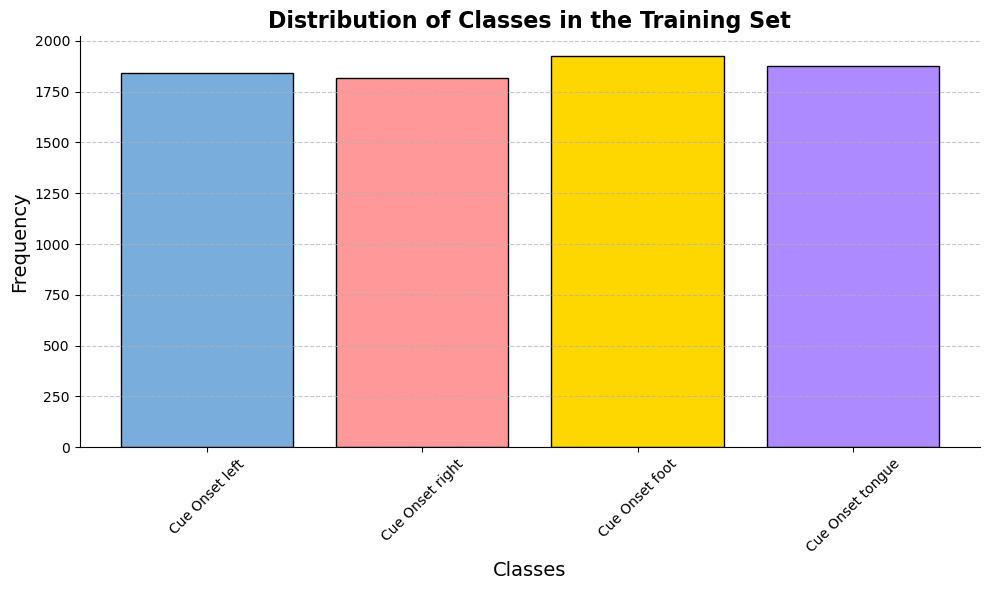

In [ ]:
class_counts = np.sum(y_train, axis=0)
class_list = ["Cue Onset left", "Cue Onset right", "Cue Onset foot", "Cue Onset tongue"]

# Making the plot look cooler with a custom color palette and design tweaks
plt.figure(figsize=(10, 6))

# Custom colors for each class
colors = ['#79addc', '#ff9999', '#ffd700', '#ad8aff']

# Create bars with different colors
plt.bar(class_list, class_counts, color=colors, edgecolor='black')

# Add title and labels with custom font sizes
plt.title('Distribution of Classes in the Training Set', fontsize=16, fontweight='bold')
plt.xlabel('Classes', fontsize=14)
plt.ylabel('Frequency', fontsize=14)

# Rotate class labels for better readability
plt.xticks(rotation=45)

# Remove the top and right spines for a cleaner look
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Adding a grid for better readability of the y-axis
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show plot with a tight layout to ensure everything fits without overlapping
plt.tight_layout()
plt.show()


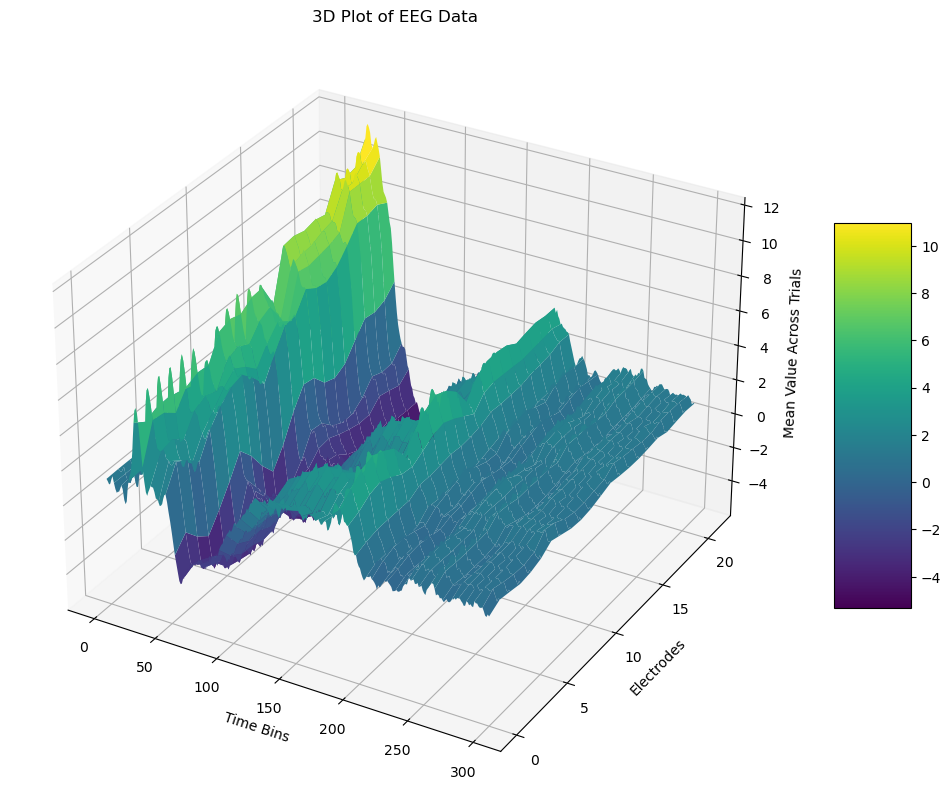

In [ ]:
x_train_reduced = np.squeeze(x_train, axis=2)

mean_across_trials = np.mean(x_train_reduced, axis=0)

time_bins = np.arange(300)
electrodes = np.arange(22)   # Y axis - 22 electrodes

T, E = np.meshgrid(time_bins, electrodes)

# Create a 3D plot
fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111, projection='3d')

surf = ax.plot_surface(T, E, mean_across_trials.T, cmap='viridis', edgecolor='none')

ax.set_xlabel('Time Bins')
ax.set_ylabel('Electrodes')
ax.set_zlabel('Mean Value Across Trials')
ax.set_title('3D Plot of EEG Data')
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()



In [ ]:
#testing GRU model

def model_cnn_with_gru_2d(input_shape, num_classes):
    l2 = regularizers.l2(0.001)
    model = models.Sequential([
        layers.Conv2D(25, (2, 1), activation='elu', input_shape=input_shape, kernel_regularizer=l2, padding='same'),
        layers.MaxPooling2D((2, 1)),
        layers.BatchNormalization(),
        layers.Dropout(0.6),

        layers.Conv2D(50, (2, 1), activation='elu', kernel_regularizer=l2, padding='same'),
        layers.MaxPooling2D((2, 1)),
        layers.BatchNormalization(),
        layers.Dropout(0.6),

        layers.Conv2D(100, (2, 1), activation='elu', kernel_regularizer=l2, padding='same'),
        layers.MaxPooling2D((3, 1)),
        layers.BatchNormalization(),
        layers.Dropout(0.6),

        layers.Conv2D(200, (2, 1), activation='elu', kernel_regularizer=l2, padding='same'),
        layers.MaxPooling2D((3, 1)),
        layers.BatchNormalization(),
        layers.Dropout(0.6),

        layers.Flatten(),
        layers.Dense(40),
        # Convert the 2D features to 1D sequence
        layers.Reshape((40,1)),  # Adjusting the shape for GRU input


        #  GRU layers
        layers.GRU(128, return_sequences=True, kernel_regularizer=l2),
        layers.GRU(64, kernel_regularizer=l2),

        layers.Dropout(0.6),
        layers.Dense(128, activation='elu', kernel_regularizer=l2),
        layers.Dropout(0.6),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

#
input_shape = (300, 1, 22)
num_classes = 4

model = model_cnn_with_gru_2d(input_shape, num_classes)

# hyparameter
learning_rate = 1e-3
optimizer = optimizers.Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()



Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, 300, 1, 25)        1125      
                                                                 
 max_pooling2d_20 (MaxPooli  (None, 150, 1, 25)        0         
 ng2D)                                                           
                                                                 
 batch_normalization_20 (Ba  (None, 150, 1, 25)        100       
 tchNormalization)                                               
                                                                 
 dropout_26 (Dropout)        (None, 150, 1, 25)        0         
                                                                 
 conv2d_21 (Conv2D)          (None, 150, 1, 50)        2550      
                                                                 
 max_pooling2d_21 (MaxPooli  (None, 75, 1, 50)        

In [ ]:
history = model.fit(x_train, y_train, batch_size=64, epochs=100, validation_data=(x_valid, y_valid), verbose=True)

Epoch 1/100
117/117 [==============================] - 8s 51ms/step - loss: 1.7865 - accuracy: 0.2625 - val_loss: 1.7075 - val_accuracy: 0.2920
Epoch 2/100
117/117 [==============================] - 6s 48ms/step - loss: 1.6493 - accuracy: 0.3214 - val_loss: 1.5600 - val_accuracy: 0.3970
Epoch 3/100
117/117 [==============================] - 6s 47ms/step - loss: 1.5381 - accuracy: 0.3993 - val_loss: 1.4766 - val_accuracy: 0.4630
Epoch 4/100
117/117 [==============================] - 6s 49ms/step - loss: 1.4607 - accuracy: 0.4292 - val_loss: 1.3921 - val_accuracy: 0.4850
Epoch 5/100
117/117 [==============================] - 6s 48ms/step - loss: 1.4097 - accuracy: 0.4540 - val_loss: 1.3959 - val_accuracy: 0.4650
Epoch 6/100
117/117 [==============================] - 6s 49ms/step - loss: 1.3690 - accuracy: 0.4731 - val_loss: 1.3355 - val_accuracy: 0.4570
Epoch 7/100
117/117 [==============================] - 6s 48ms/step - loss: 1.3354 - accuracy: 0.4897 - val_loss: 1.2904 - val_accuracy:

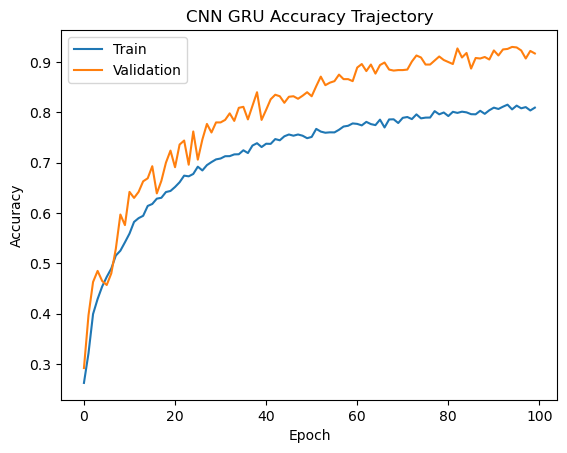

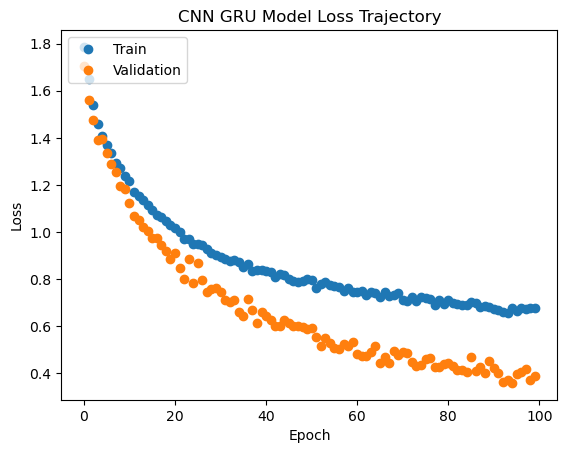

14/14 [==============================] - 0s 12ms/step - loss: 1.2756 - accuracy: 0.5847
Test Loss: 1.2755752801895142
Test Accuracy: 0.5846500992774963


In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('CNN GRU Accuracy Trajectory')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plotting loss trajectory
plt.plot(history.history['loss'], 'o')
plt.plot(history.history['val_loss'], 'o')
plt.title('CNN GRU Model Loss Trajectory')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Testing the model
test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=1)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

Subject 1 - Test Loss: 1.3796, Test Accuracy: 0.4800
Subject 2 - Test Loss: 1.8009, Test Accuracy: 0.3800
Subject 3 - Test Loss: 0.9627, Test Accuracy: 0.7200
Subject 4 - Test Loss: 1.2817, Test Accuracy: 0.5600
Subject 5 - Test Loss: 1.2494, Test Accuracy: 0.5745
Subject 6 - Test Loss: 1.4713, Test Accuracy: 0.5714
Subject 7 - Test Loss: 1.0735, Test Accuracy: 0.6400
Subject 8 - Test Loss: 1.3262, Test Accuracy: 0.5600
Subject 9 - Test Loss: 0.9157, Test Accuracy: 0.7872


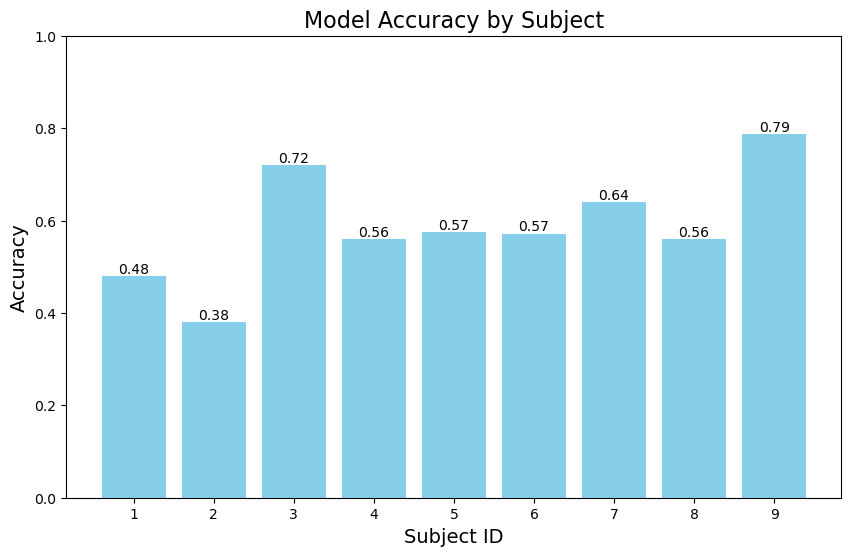

In [ ]:
evaluate_and_plot(model, x_test_by_subject, y_test_by_subject)

In [ ]:
history = model.fit(x_train_sub1, y_train_sub1, batch_size=64, epochs=100, validation_data=(x_valid_sub1, y_valid_sub1), verbose=True)

Epoch 1/100
14/14 [==============================] - 0s 32ms/step - loss: 0.7523 - accuracy: 0.7500 - val_loss: 0.4371 - val_accuracy: 0.9196
Epoch 2/100
14/14 [==============================] - 0s 32ms/step - loss: 0.6914 - accuracy: 0.7847 - val_loss: 0.4249 - val_accuracy: 0.8929
Epoch 3/100
14/14 [==============================] - 0s 32ms/step - loss: 0.6369 - accuracy: 0.7955 - val_loss: 0.4170 - val_accuracy: 0.9018
Epoch 4/100
14/14 [==============================] - 0s 31ms/step - loss: 0.5861 - accuracy: 0.8218 - val_loss: 0.3003 - val_accuracy: 0.9375
Epoch 5/100
14/14 [==============================] - 0s 30ms/step - loss: 0.5177 - accuracy: 0.8577 - val_loss: 0.3742 - val_accuracy: 0.8661
Epoch 6/100
14/14 [==============================] - 0s 30ms/step - loss: 0.5015 - accuracy: 0.8660 - val_loss: 0.3189 - val_accuracy: 0.9375
Epoch 7/100
14/14 [==============================] - 0s 33ms/step - loss: 0.5374 - accuracy: 0.8565 - val_loss: 0.3032 - val_accuracy: 0.9375
Epoch 

Subject 1 - Test Loss: 1.2582, Test Accuracy: 0.7000
Subject 2 - Test Loss: 3.5405, Test Accuracy: 0.3600
Subject 3 - Test Loss: 1.1793, Test Accuracy: 0.6400
Subject 4 - Test Loss: 3.1207, Test Accuracy: 0.3600
Subject 5 - Test Loss: 3.3698, Test Accuracy: 0.4681
Subject 6 - Test Loss: 3.4887, Test Accuracy: 0.3469
Subject 7 - Test Loss: 2.6639, Test Accuracy: 0.5400
Subject 8 - Test Loss: 2.9213, Test Accuracy: 0.5200
Subject 9 - Test Loss: 3.5086, Test Accuracy: 0.3617


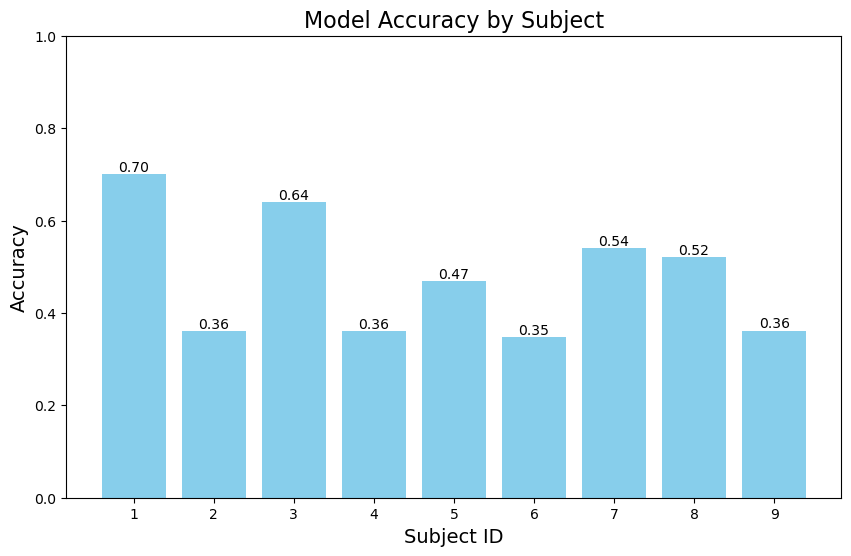

In [ ]:



evaluate_and_plot(model, x_test_by_subject, y_test_by_subject)

In [ ]:
# better GRU model

def hybrid_cnn_gru_model(input_shape, num_classes):
    l2_reg = regularizers.l2(0.001)
    model = models.Sequential([
        # Block 1
        layers.Conv2D(filters=25, kernel_size=(5, 5), padding='same', activation='elu', input_shape=input_shape, kernel_regularizer=l2_reg),
        layers.MaxPooling2D(pool_size=(3, 1), padding='same'),
        layers.BatchNormalization(),
        layers.Dropout(0.6),

        # Block 2
        layers.Conv2D(filters=50, kernel_size=(5, 5), padding='same', activation='elu', kernel_regularizer=l2_reg),
        layers.MaxPooling2D(pool_size=(3, 1), padding='same'),
        layers.BatchNormalization(),
        layers.Dropout(0.6),

        # Block 3
        layers.Conv2D(filters=100, kernel_size=(5, 5), padding='same', activation='elu', kernel_regularizer=l2_reg),
        layers.MaxPooling2D(pool_size=(3, 1), padding='same'),
        layers.BatchNormalization(),
        layers.Dropout(0.6),

        # Block 4
        layers.Conv2D(filters=200, kernel_size=(5, 5), padding='same', activation='elu', kernel_regularizer=l2_reg),
        layers.MaxPooling2D(pool_size=(3, 1), padding='same'),
        layers.BatchNormalization(),
        layers.Dropout(0.6),

        # FC+GRU Layer
        layers.Flatten(),
        layers.Dense(40),
        layers.Reshape((40, 1)),

        # Bidirectional GRU layer
        layers.Bidirectional(layers.GRU(10, dropout=0.4, recurrent_dropout=0.1, return_sequences=False)),

        # Final dense layer with softmax activation for classification
        layers.Dense(num_classes, activation='softmax')
    ])
    return model


input_shape = (300, 1, 22)
num_classes = 4

model = hybrid_cnn_gru_model(input_shape, num_classes)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()




Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 300, 1, 25)        13775     
                                                                 
 max_pooling2d (MaxPooling2  (None, 100, 1, 25)        0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 100, 1, 25)        100       
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 100, 1, 25)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 100, 1, 50)        31300     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 34, 1, 50)         0

In [ ]:

history = model.fit(x_train, y_train, batch_size=64, epochs=100, validation_data=(x_valid, y_valid), verbose=1)

Epoch 1/100
117/117 [==============================] - 7s 64ms/step - loss: 0.8548 - accuracy: 0.7472 - val_loss: 0.5929 - val_accuracy: 0.8620
Epoch 2/100
117/117 [==============================] - 7s 64ms/step - loss: 0.8657 - accuracy: 0.7425 - val_loss: 0.6232 - val_accuracy: 0.8550
Epoch 3/100
117/117 [==============================] - 8s 64ms/step - loss: 0.8693 - accuracy: 0.7410 - val_loss: 0.5970 - val_accuracy: 0.8610
Epoch 4/100
117/117 [==============================] - 8s 64ms/step - loss: 0.8618 - accuracy: 0.7436 - val_loss: 0.5687 - val_accuracy: 0.8760
Epoch 5/100
117/117 [==============================] - 8s 65ms/step - loss: 0.8583 - accuracy: 0.7446 - val_loss: 0.5810 - val_accuracy: 0.8820
Epoch 6/100
117/117 [==============================] - 7s 64ms/step - loss: 0.8450 - accuracy: 0.7539 - val_loss: 0.5952 - val_accuracy: 0.8680
Epoch 7/100
117/117 [==============================] - 8s 66ms/step - loss: 0.8623 - accuracy: 0.7433 - val_loss: 0.6028 - val_accuracy:

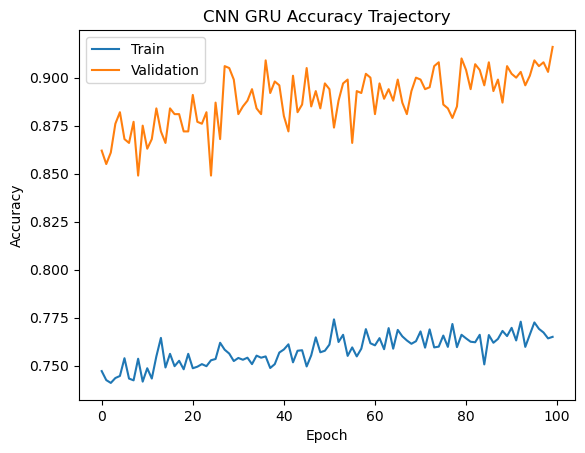

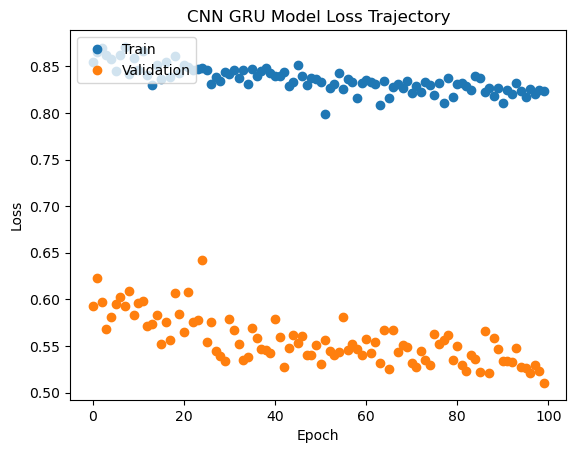

14/14 [==============================] - 0s 10ms/step - loss: 0.9420 - accuracy: 0.7178
Test Loss: 0.9419909119606018
Test Accuracy: 0.7178329825401306


In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('CNN GRU Accuracy Trajectory')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plotting loss trajectory
plt.plot(history.history['loss'], 'o')
plt.plot(history.history['val_loss'], 'o')
plt.title('CNN GRU Model Loss Trajectory')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

### Testing the model
test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=1)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

Subject 1 - Test Loss: 1.0207, Test Accuracy: 0.7000
Subject 2 - Test Loss: 1.2179, Test Accuracy: 0.5800
Subject 3 - Test Loss: 0.6631, Test Accuracy: 0.8400
Subject 4 - Test Loss: 0.9753, Test Accuracy: 0.6200
Subject 5 - Test Loss: 0.8006, Test Accuracy: 0.8085
Subject 6 - Test Loss: 1.0907, Test Accuracy: 0.6735
Subject 7 - Test Loss: 1.0403, Test Accuracy: 0.7600
Subject 8 - Test Loss: 0.8763, Test Accuracy: 0.7400
Subject 9 - Test Loss: 0.7778, Test Accuracy: 0.7447


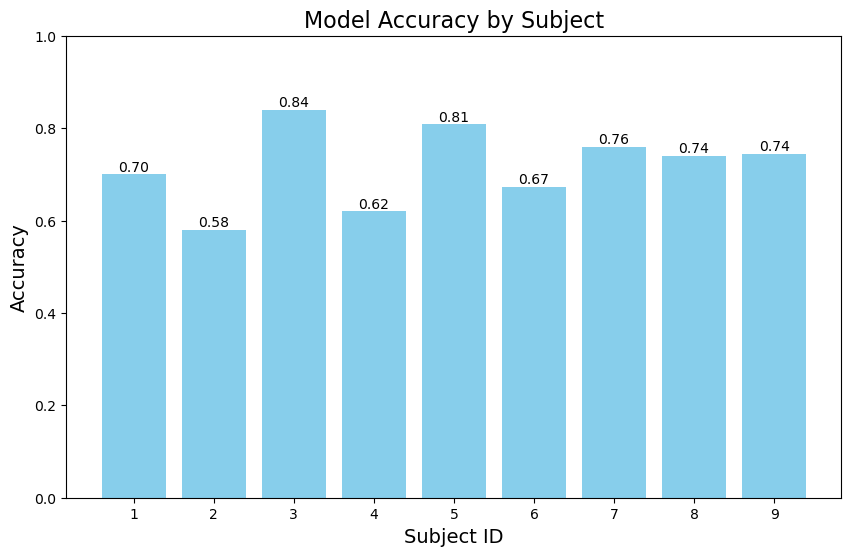

In [ ]:
evaluate_and_plot(model, x_test_by_subject, y_test_by_subject)

In [ ]:
history = model.fit(x_train_sub1, y_train_sub1, batch_size=64, epochs=100, validation_data=(x_valid_sub1, y_valid_sub1), verbose=True)

Epoch 1/100
14/14 [==============================] - 1s 65ms/step - loss: 0.7915 - accuracy: 0.7799 - val_loss: 0.4483 - val_accuracy: 0.9286
Epoch 2/100
14/14 [==============================] - 1s 61ms/step - loss: 0.6161 - accuracy: 0.8481 - val_loss: 0.3960 - val_accuracy: 0.9554
Epoch 3/100
14/14 [==============================] - 1s 63ms/step - loss: 0.6378 - accuracy: 0.8313 - val_loss: 0.3995 - val_accuracy: 0.9643
Epoch 4/100
14/14 [==============================] - 1s 61ms/step - loss: 0.5678 - accuracy: 0.8804 - val_loss: 0.3689 - val_accuracy: 0.9732
Epoch 5/100
14/14 [==============================] - 1s 64ms/step - loss: 0.5666 - accuracy: 0.8744 - val_loss: 0.3760 - val_accuracy: 0.9464
Epoch 6/100
14/14 [==============================] - 1s 61ms/step - loss: 0.5156 - accuracy: 0.8971 - val_loss: 0.3443 - val_accuracy: 0.9643
Epoch 7/100
14/14 [==============================] - 1s 63ms/step - loss: 0.4929 - accuracy: 0.8959 - val_loss: 0.3882 - val_accuracy: 0.9286
Epoch 

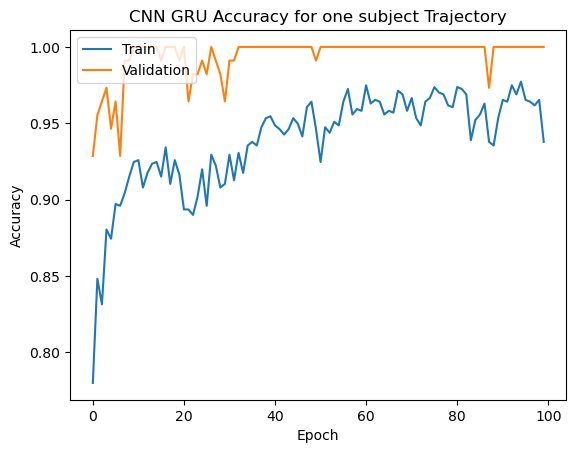

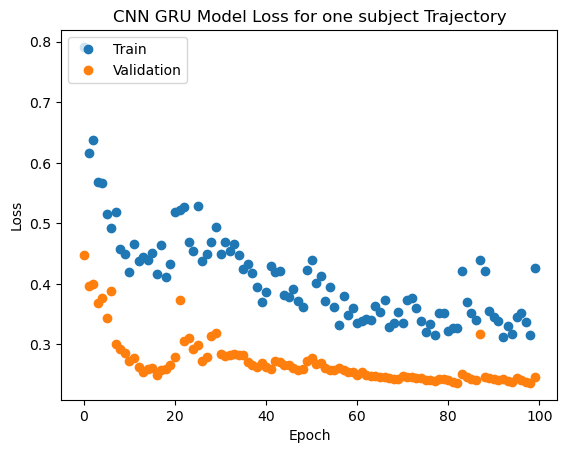

14/14 [==============================] - 0s 12ms/step - loss: 2.6360 - accuracy: 0.5011
Test Loss: 2.635958194732666
Test Accuracy: 0.5011286735534668


In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('CNN GRU Accuracy for one subject Trajectory')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plotting loss trajectory
plt.plot(history.history['loss'], 'o')
plt.plot(history.history['val_loss'], 'o')
plt.title('CNN GRU Model Loss for one subject Trajectory')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

### Testing the model
test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=1)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

14/14 [==============================] - 0s 8ms/step - loss: 2.6360 - accuracy: 0.5011
Subject 1 - Test Loss: 1.4137, Test Accuracy: 0.7400
Subject 2 - Test Loss: 2.8948, Test Accuracy: 0.4200
Subject 3 - Test Loss: 0.9960, Test Accuracy: 0.7000
Subject 4 - Test Loss: 2.3970, Test Accuracy: 0.4600
Subject 5 - Test Loss: 3.1305, Test Accuracy: 0.4468
Subject 6 - Test Loss: 3.5472, Test Accuracy: 0.3469
Subject 7 - Test Loss: 2.7217, Test Accuracy: 0.5400
Subject 8 - Test Loss: 3.2882, Test Accuracy: 0.5200
Subject 9 - Test Loss: 3.4301, Test Accuracy: 0.3191


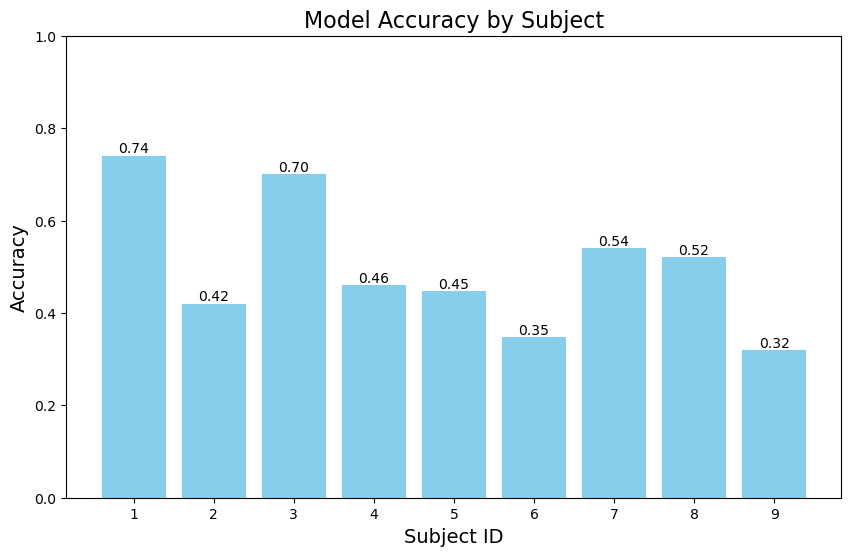

In [ ]:
test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=1)
evaluate_and_plot(model, x_test_by_subject, y_test_by_subject)